### 1. **Preparação dos Dados**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
import scipy.stats
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from scipy.stats import randint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

**Carregamento do Dataset**

*   Proporção das classes seja mantida em cada conjunto
*   Validação: 20% do conjunto de treino



In [ ]:
test_path = "test_normalized.csv"
val_path = "val_normalized.csv"
subtrain_path = "train_normalized.csv"

df_val = pd.read_csv(val_path, index_col=None)
df_test = pd.read_csv(test_path, index_col=None)
df_subtrain = pd.read_csv(subtrain_path, index_col=None)

In [ ]:
print("Validação:", df_val.shape)
print("Teste:", df_test.shape)
print("Sub-conjunto de treinamento", df_subtrain.shape)

Validação: (7200, 23)
Teste: (9000, 23)
Sub-conjunto de treinamento (28800, 23)


In [ ]:
X_train_subset = df_subtrain.drop(columns=["loan_status"])
y_train_subset  = df_subtrain["loan_status"]

X_val = df_val.drop(columns=["loan_status"])
y_val = df_val["loan_status"]

X_test = df_test.drop(columns=["loan_status"])
y_test = df_test["loan_status"]

# Unificando os conjuntos de subtreino e validação
X_train = pd.concat([X_train_subset, X_val], axis=0)
y_train= pd.concat([y_train_subset, y_val], axis=0)

**Pré-processamento**

O modelo SVM é sensível à escala dos atributos, por isso aplicamos a padronização.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Ajusta e transforma o conjunto de treino
X_train_scaled = scaler.fit_transform(X_train_subset)  # Ajusta e transforma o conjunto de treino
X_val_scaled = scaler.transform(X_val)  # Apenas transforma o conjunto de validação
X_test_scaled = scaler.transform(X_test)

### 2. **Seleção do Moelos e Hiperparâmetros**


*   C: Controle da regularização (distribuição log-uniforme).
*   kernel: Escolha entre 'rbf' e 'linear'.
*   gamma: Influência de um único exemplo (distribuição log-uniforme, usada no kernel RBF).

**Espaço de Busca**

In [ ]:
param_grid_svm = {
    'C': scipy.stats.loguniform(1e-3, 1e3),
    'kernel': ['linear', 'rbf'],
    'gamma': scipy.stats.loguniform(1e-3, 1e1)
}

### 3. **Busca de Hiperparâmetros**

**Método de Busca**

Utilizar RandomizedSearchCV do scikit-learn.

In [ ]:
# StratifiedKFold mantém a distribuição das classes.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definimos 20 iterações para buscar os melhores hiperparâmetros.
svm = SVC()
search_svm = RandomizedSearchCV(svm, param_grid_svm, n_iter=20, cv=cv, scoring='f1_macro', n_jobs=-1, random_state=42)

**Validação Cruzada**

Método holdout de validação cruzada

In [ ]:
# Executando a Busca de Hiperparâmetros
search_svm.fit(X_train_scaled, y_train_subset)

# Seleção do Melhor Modelo
best_svm = search_svm.best_estimator_

# Avaliação no Conjunto de Validação
y_pred_val = best_svm.predict(X_val_scaled)
print("Relatório de Classificação para SVM no Conjunto de Validação:")
print(classification_report(y_val, y_pred_val))

Relatório de Classificação para SVM no Conjunto de Validação:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      5600
           1       0.83      0.74      0.78      1600

    accuracy                           0.91      7200
   macro avg       0.88      0.85      0.86      7200
weighted avg       0.91      0.91      0.91      7200



**Registro de Desempenho**

In [ ]:
# Exibindo os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros para SVM:")
print(search_svm.best_params_)

Melhores hiperparâmetros para SVM:
{'C': np.float64(9.443515687962675), 'gamma': np.float64(0.017654048052495083), 'kernel': 'rbf'}


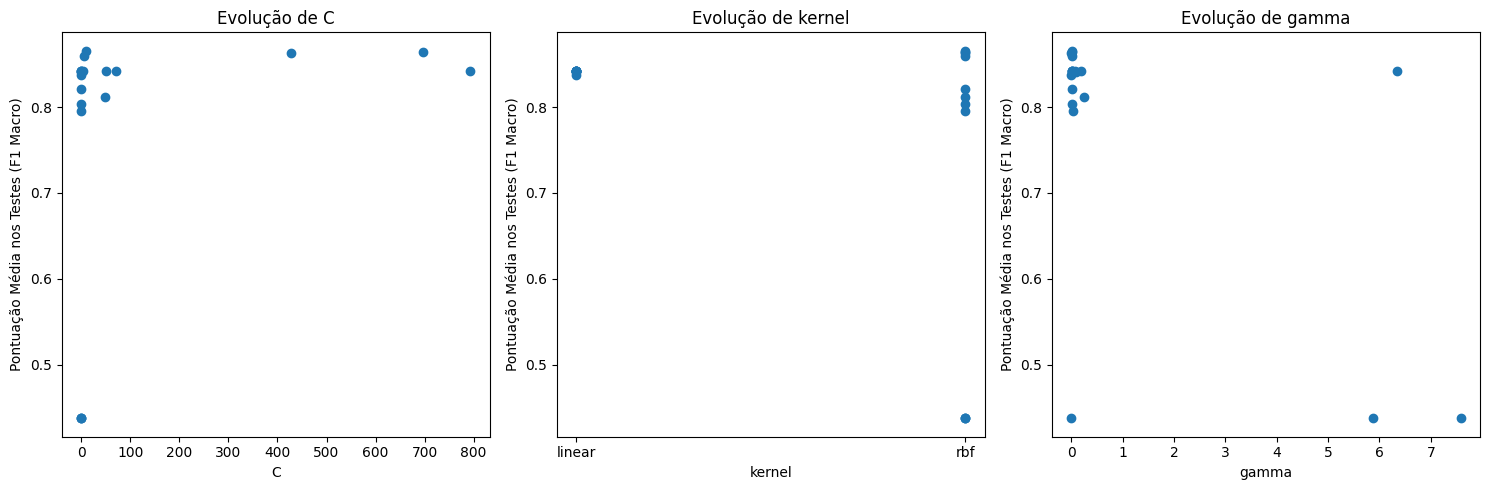

In [ ]:
results = search_svm.cv_results_

param_values = [v for v in results['params']]  # param_values será uma lista de dicionários
mean_test_scores = results['mean_test_score']

fig, axes = plt.subplots(1, len(param_grid_svm), figsize=(15, 5))  # Crie subplots para cada hiperparâmetro

param_names = list(param_grid_svm.keys())  # Obtenha os nomes dos hiperparâmetros

for i, param_name in enumerate(param_names):
  ax = axes[i]
  # Extraia os valores do hiperparâmetro atual de param_values
  param_values_for_plot = [param.get(param_name) for param in param_values]
  ax.scatter(param_values_for_plot, mean_test_scores)
  ax.set_xlabel(param_name)
  ax.set_ylabel('Pontuação Média nos Testes (F1 Macro)')
  ax.set_title(f'Evolução de {param_name}')

plt.tight_layout()
plt.show()

### 4. **Treinamento Final e Avaliação**

Treinamento do modelo no conjunto de treinamento e avaliação no conjunto de teste

In [ ]:
# Treinar o modelo
best_svm.fit(X_train, y_train)

# Avaliação no Conjunto de Teste
y_pred_svm = best_svm.predict(X_test_scaled)

# Exibição dos Resultados Finais
print("Relatório de Classificação para SVM no Conjunto de Teste:")
print(classification_report(y_test, y_pred_svm))

Relatório de Classificação para SVM no Conjunto de Teste:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7000
           1       0.84      0.76      0.80      2000

    accuracy                           0.91      9000
   macro avg       0.89      0.86      0.87      9000
weighted avg       0.91      0.91      0.91      9000



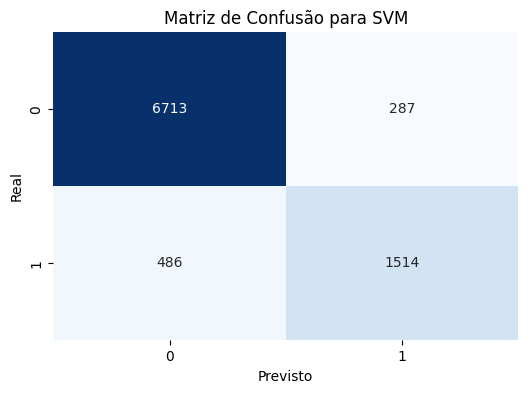

In [ ]:
# Calculando a matriz de confusão
cm = confusion_matrix(y_test, y_pred_svm)

# Criando um heatmap para visualização
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Adicionando rótulos
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão para SVM")
plt.show()
